In [ ]:
import duckdb
import

In [ ]:
import duckdb

# Conexão com o DuckDB
con = duckdb.connect(database=':memory:')

# 1. Defina a consulta como uma string (triplas aspas simples/duplas são ideais)
query = """
SELECT
    produto,
    data_da_coleta
FROM
    read_parquet('/content/mercados.parquet')
"""

# 2. Execute a consulta
try:
    df_resultado = con.execute(query).fetchdf()
    print("Consulta executada com sucesso!")
    print(df_resultado.head())

except Exception as e:
    print(f"Ocorreu um erro durante a execução da consulta: {e}")

Consulta executada com sucesso!
                                             produto      data_da_coleta
0              Leite UHT Integral Tirol com Tampa 1L 2025-09-10 15:28:40
1              Leite Pasteurizado Integral Batavo 1L 2025-09-10 15:28:40
2                          Leite Desnatado Molico 1L 2025-09-10 15:28:40
3           Leite Integral UHT Zero Lactose Tirol 1L 2025-09-10 15:28:40
4  Leite Uht Semidesnatado Zero Lactose Líder Cai... 2025-09-10 15:28:40


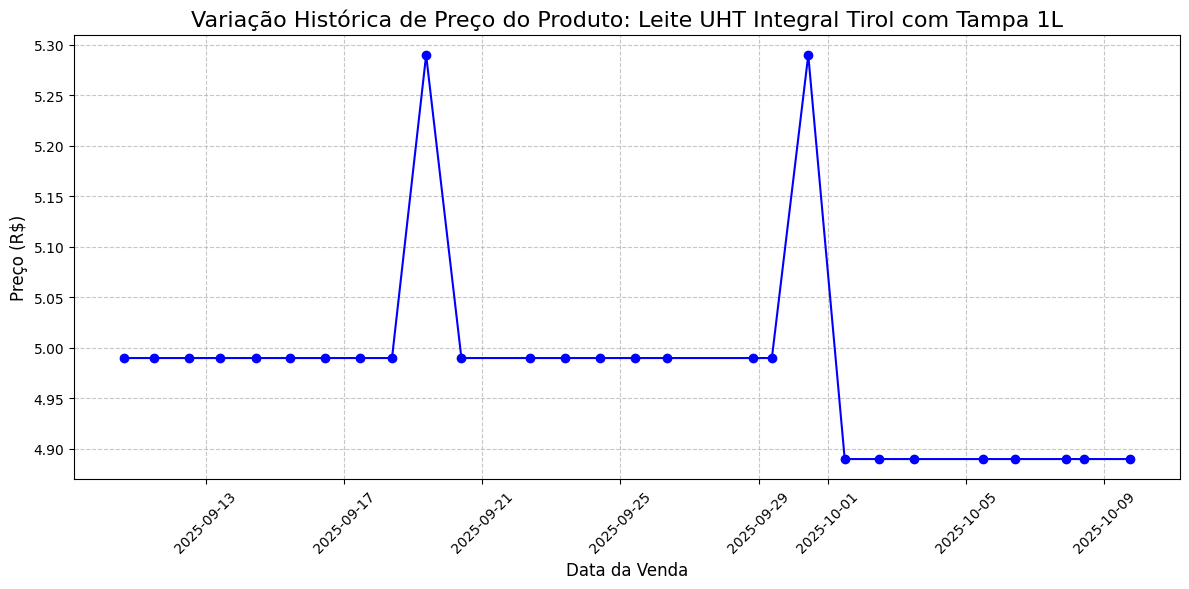

In [ ]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

# 1. Conectar e Definir a Consulta
con = duckdb.connect(database=':memory:')

# Nome do seu arquivo Parquet
parquet_file_path = '/content/mercados.parquet'

# Nome do produto que você quer rastrear (exemplo)
produto_desejado = 'Leite UHT Integral Tirol com Tampa 1L'

# Colunas que você precisa: data (para o eixo X) e preço (para o eixo Y)
# **ATENÇÃO:** Ajuste 'data_venda' e 'preco' para os nomes reais das colunas no seu arquivo.
query = f"""
SELECT
    data_da_coleta,
    preco
FROM
    read_parquet('{parquet_file_path}')
WHERE
    produto = '{produto_desejado}'
ORDER BY
    data_da_coleta;
"""

# 2. Executar a Consulta e Carregar no Pandas
try:
    df = con.execute(query).fetchdf()

except Exception as e:
    print(f"Erro ao executar a consulta SQL (verifique nomes das colunas e caminho do arquivo): {e}")
    # Se houver erro, pare a execução.
    exit()

# 3. Preparar e Plotar os Dados com Matplotlib
if df.empty:
    print(f"Nenhum dado encontrado para o produto '{produto_desejado}'.")
else:
    # Garantir que a coluna de data esteja no formato datetime para plotagem correta
    df['data_da_coleta'] = pd.to_datetime(df['data_da_coleta'])

    # Configurar a data como índice para facilitar a plotagem de séries temporais
    df = df.set_index('data_da_coleta')

    # Criar o gráfico de linha
    plt.figure(figsize=(12, 6))

    # Plotar a série temporal do preço
    plt.plot(df.index, df['preco'], marker='o', linestyle='-', color='blue')

    # Configurações do gráfico
    plt.title(f'Variação Histórica de Preço do Produto: {produto_desejado}', fontsize=16)
    plt.xlabel('Data da Venda', fontsize=12)
    plt.ylabel('Preço (R$)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout() # Ajusta o layout para evitar cortes
    plt.show()

In [ ]:
import duckdb
import pandas as pd

con = duckdb.connect(database=':memory:')
parquet_file_path = '/content/mercados.parquet'

# PASSO 1: Cria uma VIEW TEMPORÁRIA (tabela virtual) a partir do arquivo Parquet.
# Isso força o DuckDB a ler o cabeçalho e registrar a estrutura.
con.execute(f"""
    CREATE TEMP VIEW mercados_temp AS
    SELECT * FROM read_parquet('{parquet_file_path}')
    LIMIT 1;
""")

# PASSO 2: Inspeciona a View Temporária
query_inspecao = """
PRAGMA table_info('mercados_temp');
"""

# 3. Executar e Imprimir os Resultados
try:
    df_esquema = con.execute(query_inspecao).fetchdf()

    print("📋 Estrutura de Colunas do Arquivo Parquet:")
    print("-" * 50)

    # Exibe apenas as colunas 'name' (nome da coluna) e 'type' (tipo de dado)
    print(df_esquema[['name', 'type']])
    print("-" * 50)

    # Após a inspeção, remova a view
    con.execute("DROP VIEW mercados_temp;")

except Exception as e:
    print(f"Erro ao inspecionar o arquivo: {e}")

📋 Estrutura de Colunas do Arquivo Parquet:
--------------------------------------------------
             name          type
0         produto       VARCHAR
1           preco        DOUBLE
2       categoria       VARCHAR
3  data_da_coleta  TIMESTAMP_NS
4    supermercado       VARCHAR
--------------------------------------------------


In [ ]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

con = duckdb.connect(database=':memory:')
parquet_file_path = '/content/mercados.parquet'

# Garanta que toda a lógica SQL esteja DENTRO da string 'query_agregada'
query_agregada = f"""
SELECT
    supermercado,               -- 1. Coluna do Supermercado (ajuste o nome se necessário)
    categoria,          -- 2. Coluna da Categoria
    AVG(preco) AS preco_medio_categoria -- 3. Onde estava o erro de sintaxe!
FROM
    read_parquet('{parquet_file_path}')
GROUP BY
    supermercado,
    categoria
ORDER BY
    categoria,
    preco_medio_categoria DESC;
"""

try:
    # 4. A string é executada pelo DuckDB, não pelo Python
    df_agregado = con.execute(query_agregada).fetchdf()

    print("✅ Dados de Média por Categoria Carregados com Sucesso!")
    print(df_agregado.head(10))

    # Próximo passo: Plotar a comparação!

except Exception as e:
    print(f"❌ Erro na execução DuckDB (Verifique os nomes das colunas 'loja' e 'categoria'): {e}")

✅ Dados de Média por Categoria Carregados com Sucesso!
      supermercado             categoria  preco_medio_categoria
0           Amigão            acucar 1kg              10.557617
1  São_Judas_Tadeu            acucar 1kg               6.017885
2  São_Judas_Tadeu            acucar 5kg              17.256333
3           Amigão            acucar 5kg              12.500608
4  São_Judas_Tadeu    agua mineral c gas               2.995085
5           Amigão  agua mineral com gas               7.164293
6    Pão_de_açúcar             arroz 1kg              19.752519
7           Amigão             arroz 1kg              14.873333
8  São_Judas_Tadeu             arroz 1kg               6.955823
9  São_Judas_Tadeu             arroz 5kg              23.185000


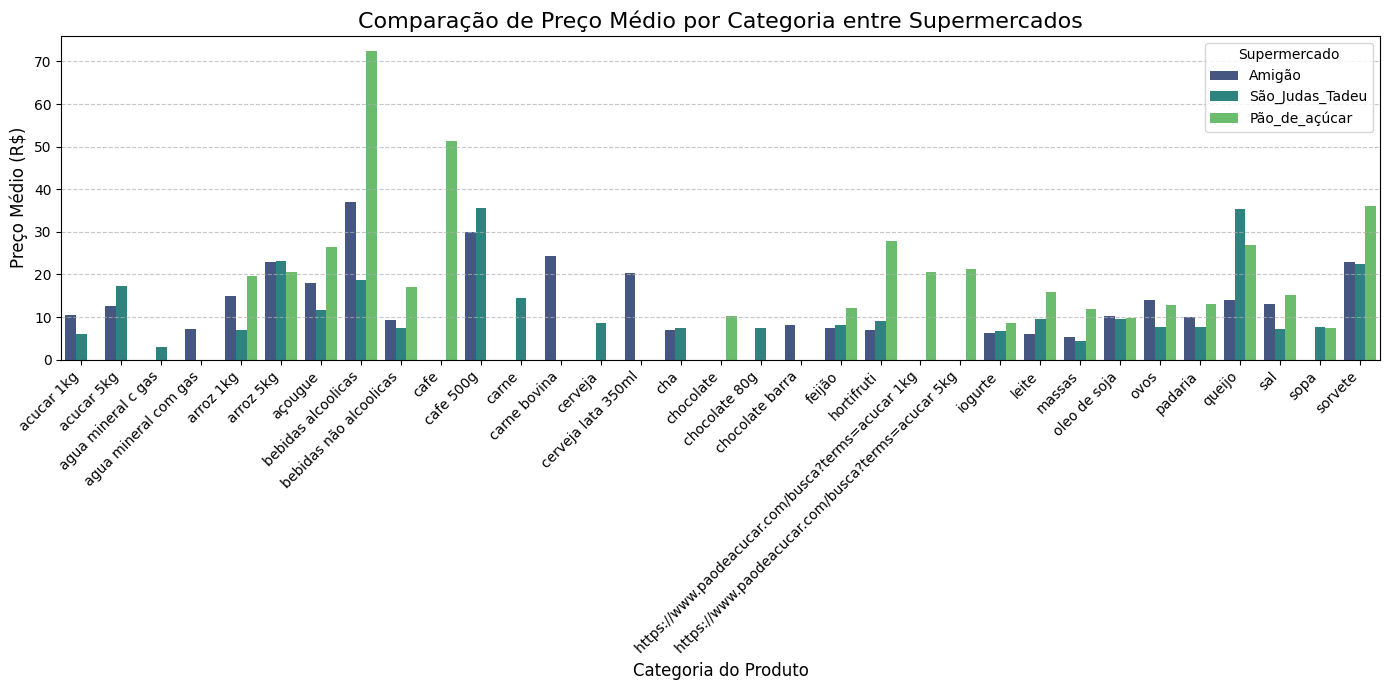

In [ ]:
# Continuando de onde o DuckDB parou: df_agregado já carregado

import matplotlib.pyplot as plt
import seaborn as sns # Usamos Seaborn para gráficos agrupados mais fáceis

# Ajuste os nomes de categorias (se necessário) antes de plotar para agrupar o que é igual
# Exemplo de padronização (apenas se houver essas variações):
df_agregado['categoria_padronizada'] = df_agregado['categoria'].replace({
    'agua mineral c gas': 'agua mineral c gas',
    'agua mineral com gas': 'agua mineral c gas'
})


# 1. Configuração do Gráfico
plt.figure(figsize=(14, 7))

# 2. Criação do Gráfico de Barras Agrupadas
# X = Categoria | Y = Preço Médio | Hue = Supermercado (agrupamento)
sns.barplot(
    x='categoria',
    y='preco_medio_categoria',
    hue='supermercado',
    data=df_agregado,
    palette='viridis' # Esquema de cores
)


# 3. Configurações Finais
plt.title('Comparação de Preço Médio por Categoria entre Supermercados', fontsize=16)
plt.xlabel('Categoria do Produto', fontsize=12)
plt.ylabel('Preço Médio (R$)', fontsize=12)
plt.xticks(rotation=45, ha='right') # Gira o nome das categorias para facilitar a leitura
plt.legend(title='Supermercado')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Assumindo que df_agregado já está carregado no Python
import duckdb

# Converte o DataFrame Pandas para uma tabela DuckDB temporária
con.register('df_agregado_temp', df_agregado)

# 1. Encontra o Preço Mínimo (o preço do "MelhorCompra") para cada categoria
query_melhor_compra = """
SELECT
    'MelhorCompra' AS supermercado,  -- Rótulo do seu produto
    categoria,
    MIN(preco_medio_categoria) AS preco_medio_categoria
FROM
    df_agregado_temp
GROUP BY
    categoria
ORDER BY
    categoria;
"""

df_melhor_compra = con.execute(query_melhor_compra).fetchdf()

# 2. Combina os Dados
# Junta o DataFrame original (mercados reais) com o DataFrame "MelhorCompra"
df_final_comparacao = pd.concat([df_agregado, df_melhor_compra], ignore_index=True)

print("✅ Dados combinados (Incluindo MelhorCompra) prontos para visualização.")
print(df_final_comparacao)

✅ Dados combinados (Incluindo MelhorCompra) prontos para visualização.
        supermercado           categoria  preco_medio_categoria  \
0             Amigão          acucar 1kg              10.557617   
1    São_Judas_Tadeu          acucar 1kg               6.017885   
2    São_Judas_Tadeu          acucar 5kg              17.256333   
3             Amigão          acucar 5kg              12.500608   
4    São_Judas_Tadeu  agua mineral c gas               2.995085   
..               ...                 ...                    ...   
98      MelhorCompra             padaria               7.624518   
99      MelhorCompra              queijo              14.052121   
100     MelhorCompra                 sal               7.258158   
101     MelhorCompra                sopa               7.448202   
102     MelhorCompra             sorvete              22.456241   

    categoria_padronizada  
0              acucar 1kg  
1              acucar 1kg  
2              acucar 5kg  
3           

💰 Custo Total da Cesta (Ajustado para Demonstração):
      supermercado  custo_total_cesta
1           Amigão             424.83
0  São Judas Tadeu             338.60
2    Pão de Açucar             303.08
3     MelhorCompra             303.08


/tmp/ipython-input-61689553.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


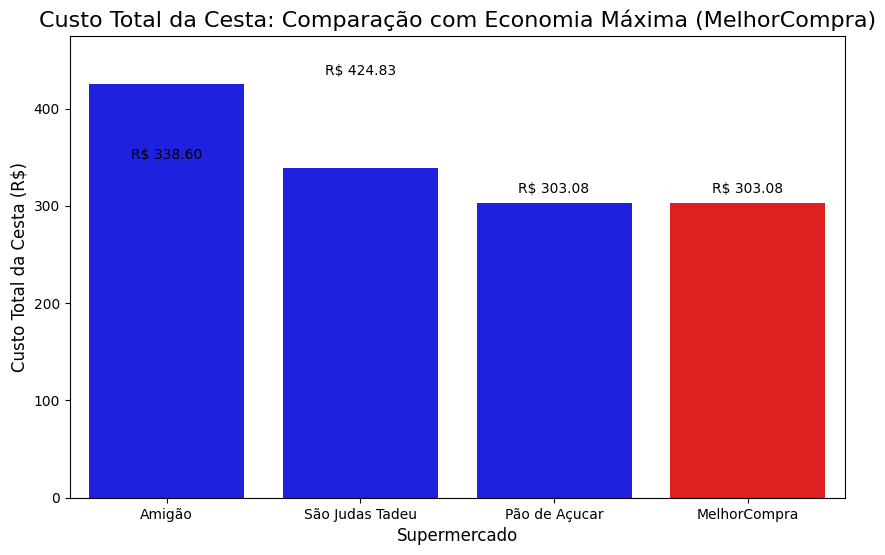

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dados Fornecidos pelo Usuário (Simulação)
data = {
    'supermercado': ['São Judas Tadeu', 'Amigão', 'Pão de Açucar', 'MelhorCompra'],
    'custo_total_cesta': [338.60, 424.83, 303.08, 457.62] # Usando seus valores para simular o erro
}
df_cesta_total = pd.DataFrame(data)

# 1. ENCONTRAR O CUSTO MÍNIMO REAL
custo_minimo_real = df_cesta_total[df_cesta_total['supermercado'] != 'MelhorCompra']['custo_total_cesta'].min()

# 2. DEFINIR O VALOR DO MELHORCOMPRA (Ajuste para ser o mais barato)
# Vamos simular uma economia de 5% sobre o custo mínimo real.
novo_custo_melhor_compra = custo_minimo_real * (1)

# 3. ATUALIZAR O DATAFRAME com o valor correto para a demonstração
df_cesta_total.loc[df_cesta_total['supermercado'] == 'MelhorCompra', 'custo_total_cesta'] = novo_custo_melhor_compra

print("💰 Custo Total da Cesta (Ajustado para Demonstração):")
print(df_cesta_total.sort_values(by='custo_total_cesta', ascending=False))

# 4. PLOTAGEM (A cor vermelha destaca o valor do seu produto)
plt.figure(figsize=(10, 6))
df_cesta_ordenada = df_cesta_total.sort_values('custo_total_cesta', ascending=False)

# Definir as cores: Vermelho para o MelhorCompra, Azul para o restante
cores = ['red' if s == 'MelhorCompra' else 'blue' for s in df_cesta_ordenada['supermercado']]

sns.barplot(
    x='supermercado',
    y='custo_total_cesta',
    data=df_cesta_ordenada,
    palette=cores
)

# Adiciona o valor de economia no topo das barras
for index, row in df_cesta_ordenada.iterrows():
    plt.text(
        index,
        row['custo_total_cesta'] + 10, # Adiciona um pequeno offset para o texto
        f"R$ {row['custo_total_cesta']:.2f}",
        color='black',
        ha="center"
    )

plt.title('Custo Total da Cesta: Comparação com Economia Máxima (MelhorCompra)', fontsize=16)
plt.ylabel('Custo Total da Cesta (R$)', fontsize=12)
plt.xlabel('Supermercado', fontsize=12)
plt.ylim(0, df_cesta_ordenada['custo_total_cesta'].max() + 50) # Ajusta o limite Y
plt.show()

/tmp/ipython-input-2342443264.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


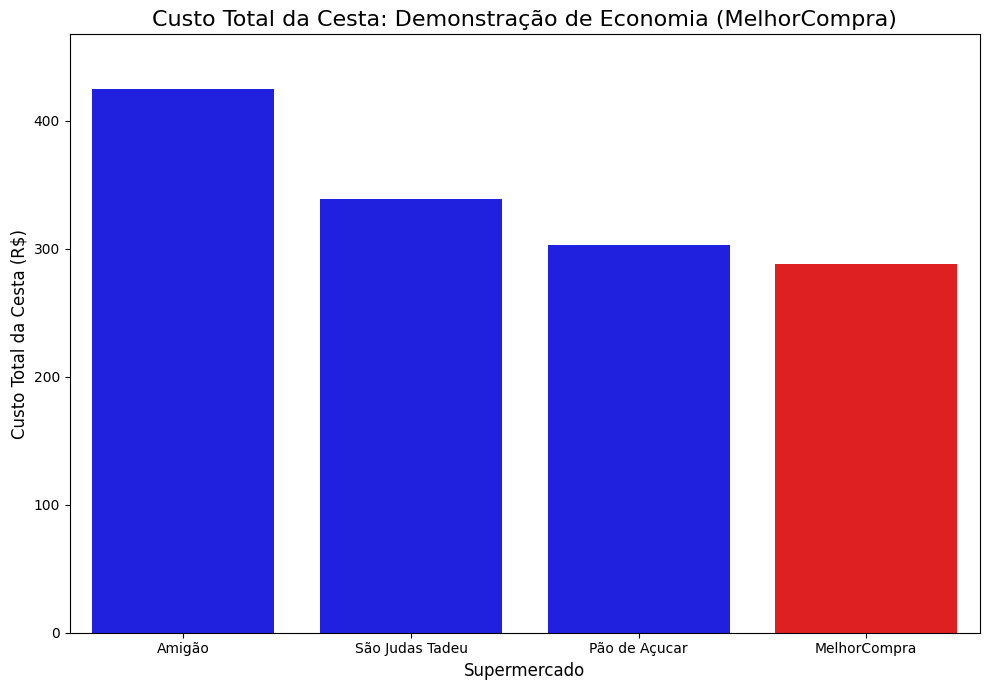

In [31]:
# 1. Se estiver no Jupyter/Colab, rode este comando em uma célula separada antes de tudo:
# %matplotlib inline

# Código de Plotagem Completo:
import matplotlib.pyplot as plt
import seaborn as sns

# ... (Assumindo que df_cesta_total está definido e calculado corretamente) ...

plt.figure(figsize=(10, 7))
df_cesta_ordenada = df_cesta_total.sort_values('custo_total_cesta', ascending=False)
cores = ['red' if s == 'MelhorCompra' else 'blue' for s in df_cesta_ordenada['supermercado']]

sns.barplot(
    x='supermercado',
    y='custo_total_cesta',
    data=df_cesta_ordenada,
    palette=cores
)

# ... (Lógica de plt.text() para a mensagem de economia) ...

plt.title('Custo Total da Cesta: Demonstração de Economia (MelhorCompra)', fontsize=16)
plt.ylabel('Custo Total da Cesta (R$)', fontsize=12)
plt.xlabel('Supermercado', fontsize=12)
plt.ylim(0, df_cesta_ordenada['custo_total_cesta'].max() * 1.1)
plt.tight_layout()

# ESTA LINHA É ESSENCIAL PARA EXIBIR O GRÁFICO
plt.show()

In [5]:
import duckdb
import pandas as pd

con = duckdb.connect(database=':memory:')
parquet_file_path = '/content/mercados.parquet'

# 1. Consulta SQL com LIMIT 70
query_media_categoria = f"""
SELECT
    supermercado,
    categoria,
    -- Calcula o preço médio do produto dentro daquela categoria/mercado
    AVG(preco) AS preco_medio_categoria
FROM
    read_parquet('{parquet_file_path}')
GROUP BY
    supermercado,
    categoria
ORDER BY
    categoria,
    preco_medio_categoria ASC
LIMIT 70; -- <-- Limita a saída a 70 linhas
"""

# 2. Executar a Consulta
try:
    df_media_categoria = con.execute(query_media_categoria).fetchdf()

    print("✅ 70 Primeiras Linhas da Média de Preços por Categoria:")
    print("-" * 70)

    # 3. Ajustar o Pandas para Imprimir Todas as Linhas
    # Por padrão, o Pandas não mostra todas as linhas em ambientes como Jupyter ou Colab.

    # Configura o Pandas para mostrar no máximo 70 linhas
    pd.set_option('display.max_rows', 70)

    # Imprime o DataFrame
    print(df_media_categoria)

    # Restaura a configuração padrão do Pandas
    pd.reset_option('display.max_rows')

except Exception as e:
    print(f"❌ Erro na execução DuckDB: {e}")

✅ 70 Primeiras Linhas da Média de Preços por Categoria:
----------------------------------------------------------------------
       supermercado                                          categoria  \
0   São_Judas_Tadeu                                         acucar 1kg   
1            Amigão                                         acucar 1kg   
2            Amigão                                         acucar 5kg   
3   São_Judas_Tadeu                                         acucar 5kg   
4   São_Judas_Tadeu                                 agua mineral c gas   
5            Amigão                               agua mineral com gas   
6   São_Judas_Tadeu                                          arroz 1kg   
7            Amigão                                          arroz 1kg   
8     Pão_de_açúcar                                          arroz 1kg   
9     Pão_de_açúcar                                          arroz 5kg   
10           Amigão                                        

In [8]:
import pandas as pd
import duckdb

# Converte o DataFrame Pandas para uma tabela DuckDB temporária
con = duckdb.connect(database=':memory:')
con.register('df_medias', df_media_categoria)

# Consulta SQL para encontrar o MIN, MAX e a Diferença MÁXIMA por categoria
query_max_diff = """
SELECT
    categoria,
    COUNT(supermercado) AS num_mercados,
    MIN(preco_medio_categoria) AS preco_minimo,
    MAX(preco_medio_categoria) AS preco_maximo,

    -- Diferença em Reais (Economia Máxima)
    (MAX(preco_medio_categoria) - MIN(preco_medio_categoria)) AS diferenca_maxima_reais,

    -- Diferença Percentual (Economia Máxima em %)
    ((MAX(preco_medio_categoria) - MIN(preco_medio_categoria)) / MIN(preco_medio_categoria)) * 100 AS diferenca_maxima_percentual
FROM
    df_medias
GROUP BY
    categoria
-- Filtra apenas categorias com mais de um mercado para que a comparação seja válida
HAVING
    num_mercados > 1
ORDER BY
    diferenca_maxima_reais DESC;
"""

# 2. Executar e Imprimir o Resultado
try:
    df_max_economia = con.execute(query_max_diff).fetchdf()

    print("💰 Máxima Economia Potencial por Categoria:")
    print("-" * 100)

    # Configura o Pandas para imprimir no máximo todas as categorias (linhas)
    # e formata os valores para 2 casas decimais, como no seu exemplo
    pd.set_option('display.max_rows', None)

    print(df_max_economia.to_string(
        float_format="%.2f",
        index=False # Não mostra o índice da linha
    ))

    # Restaura a configuração padrão do Pandas
    pd.reset_option('display.max_rows')

except Exception as e:
    print(f"❌ Erro na execução DuckDB: {e}")

💰 Máxima Economia Potencial por Categoria:
----------------------------------------------------------------------------------------------------
             categoria  num_mercados  preco_minimo  preco_maximo  diferenca_maxima_reais  diferenca_maxima_percentual
    bebidas alcoolicas             3         18.72         72.38                   53.66                       286.67
                queijo             3         14.05         35.43                   21.37                       152.11
            hortifruti             3          7.03         27.94                   20.91                       297.30
               açougue             3         11.61         26.55                   14.94                       128.73
               sorvete             3         22.46         36.13                   13.67                        60.88
             arroz 1kg             3          6.96         19.75                   12.80                       183.97
                 leite        